<a href="https://colab.research.google.com/github/el-grudge/Introduction-to-Adversarial-Attacks/blob/main/Copy_of_Copy_of_Copy_of_AdversarialAdversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main

## Setup

In [ ]:
!pip install olympic

In [ ]:
# ---------------------------------------------------------------------------- #
# An implementation of https://arxiv.org/pdf/1512.03385.pdf                    #
# See section 4.2 for the model architecture on CIFAR-10                       #
# Some part of the code was referenced from below                              #
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# ---------------------------------------------------------------------------- #

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import json
import numpy as np
import olympic
import matplotlib.pyplot as plt
from argparse import Namespace
from tqdm.notebook import tqdm

from resnet import *
from utils import *

import sys
sys.path.append('./adversarial/')
from functional import boundary, iterated_fgsm, local_search, fgsm, pgd

from google.colab import files

In [ ]:
args = Namespace(
    # Seed
    seed = 832,
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    # Network parameters
    batch_size = 64,
    num_epochs = 50,
    learning_rate = 0.001,
    # Adversary parameters
    epsilon = .03,
    adversarial_training = False,
    adversarial_testing = False,
)

In [ ]:
np.random.seed(args.seed)
torch.cuda.manual_seed_all(args.seed) if torch.cuda.is_available() else torch.manual_seed(args.seed)

In [ ]:
train, val = get_datasets()
train_loader, val_loader = get_dataloaders(train, val, args.batch_size)

Files already downloaded and verified


## Natural Training

In [ ]:
# Model
net_args = {
    "block": ResidualBlock,
    "channels": train_loader.dataset[0][0].shape[0],
    "layers": [2, 2, 2],
    "num_classes": 10
    }
model = ResNet(**net_args).to(args.device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=args.learning_rate)
scheduler = ReduceLROnPlateau(optimizer, patience = 5)

In [ ]:
# Train the model
train_acc = []
val_acc = []

for epoch in range(args.num_epochs):
  model.train()
  total = 0
  correct = 0

  pbar = tqdm(total=len(train_loader), desc='Epoch {}'.format(epoch+1))
  
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    # Train on original images
    outputs, loss = forward_pass(model, images, labels, loss_fn, optimizer)
    
    if args.adversarial_training:
      # Create adversarial examples
      images_adv = fgsm_attack(images, args.epsilon, images.grad.data)
      
      # Train on adversarial images
      outputs, loss = forward_pass(model, images_adv, labels, loss_fn, optimizer)
    
    pred = torch.max(outputs.data, 1)[1]  
    total += labels.size(0)
    correct += (pred == labels).sum().item()
    
    pbar.update(1)
    
  train_acc.append(correct / total)
  
  # Test the model
  model.eval()
  total = 0
  correct = 0
  
  for images, labels in val_loader:
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    outputs = model(images)
    val_loss = loss_fn(outputs, labels)
    
    if args.adversarial_testing:
      val_loss.backward()
      perturbed_images = fgsm_attack(images, args.epsilon, images.grad.data)
      
      outputs = model(perturbed_images.to(args.device))
      val_loss = loss_fn(outputs, labels)
	  
    pred = torch.max(outputs.data, 1)[1] # save the prediction of the adversarial sample
    total += labels.size(0)
    correct += (pred == labels).sum().item()

  val_acc.append(correct / total)
  
  curr_lr = optimizer.param_groups[0]['lr']
  scheduler.step(train_acc[epoch])
  
  pbar_dict = {'loss':loss.item(),
               'acc':train_acc[epoch],
               'val_loss': val_loss.item(),
               'val_acc':val_acc[epoch],
               'LR':curr_lr}

  pbar.set_postfix(pbar_dict)

In [ ]:
# Save models
torch.save(model, './data/models/model_cifar_resnet18_epochs=50_natural.pt')
# Download models
files.download('./data/models/model_cifar_resnet18_epochs=50_natural.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
olympic.evaluate(model, val_loader, metrics=['accuracy'],
                 prepare_batch = lambda batch: (batch[0].to(args.device), batch[1].to(args.device)))

{'val_accuracy': 0.8415}

In [ ]:
train_results = {'train_acc': train_acc, 'val_acc': val_acc}

with open('./data/results/train_results.json', 'w') as f:
    json.dump(train_results, f)

No handles with labels found to put in legend.


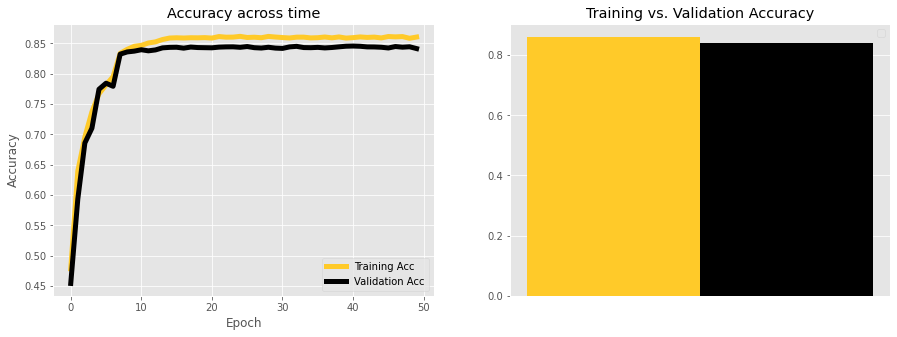

<Figure size 1008x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    
    index = np.arange(1)
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(14,7))
    
    axes[0].set_title('Accuracy across time')
    axes[0].plot(train_results['train_acc'], label='Training Acc', color='#ffca29', linewidth=5)
    axes[0].plot(train_results['val_acc'], label='Validation Acc', color='black', linewidth=5)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    axes[1].set_title('Training vs. Validation Accuracy')
    axes[1].bar(index, train_results['train_acc'][-1], 0.2, color='#ffca29')
    axes[1].bar(index+0.2, train_results['val_acc'][-1], 0.2, color='black')
    axes[1].set_xticks([])
    axes[1].legend()
    
    plt.show()
    plt.savefig('./data/images/naturalTraining.png')

In [ ]:
files.download('./data/images/naturalTraining1.png')
files.download('./data/results/train_results.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load natural models
model = torch.load('./data/models/model_cifar_resnet18_epochs=50_natural.pt')

In [ ]:
olympic.evaluate(model, val_loader, metrics=['accuracy'],
                 prepare_batch = lambda batch: (batch[0].to(args.device), batch[1].to(args.device)))

{'val_accuracy': 0.8415}

## Attack with FGSM

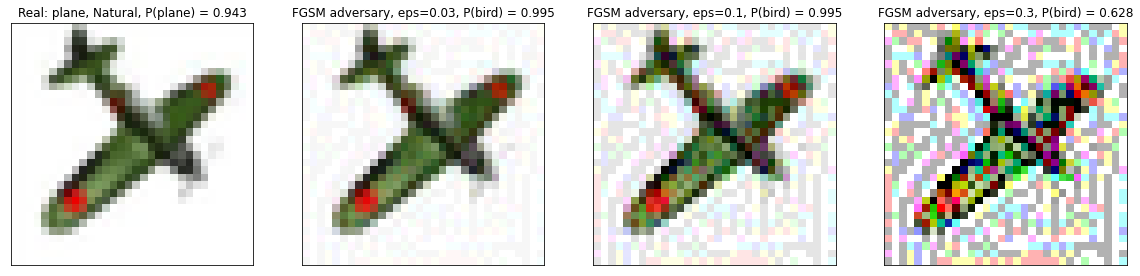

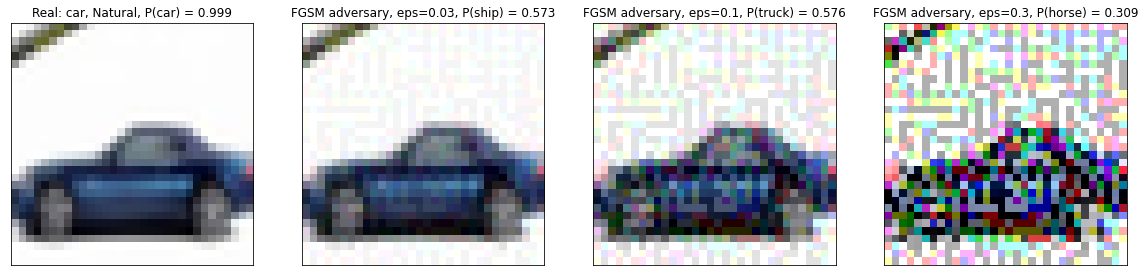

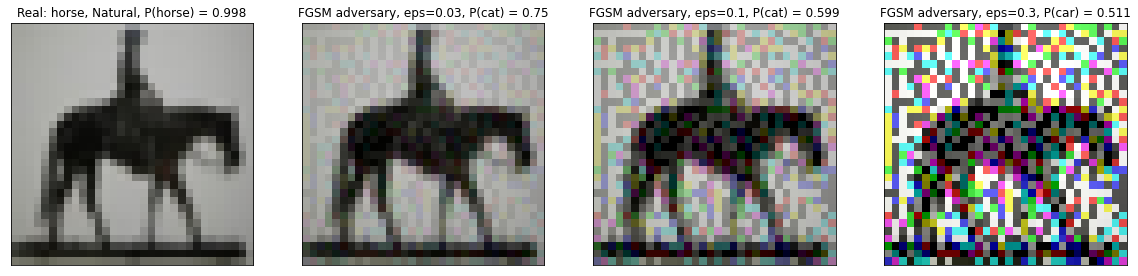

In [ ]:
visualise_adversarial_examples_fgsm(model, *val[98], args.device)
visualise_adversarial_examples_fgsm(model, *val[105], args.device)
visualise_adversarial_examples_fgsm(model, *val[288], args.device)

## Quantifying adversarial accuracy

In [ ]:
fgsm_attack_range = np.arange(0.0, 0.3, 0.01)
fgsm_acc = []
for eps in fgsm_attack_range:
    fgsm_acc.append(evaluate_against_adversary(model, val_loader, k=1, eps=eps, step=1, norm='fgsm', device=args.device))

In [ ]:
fgsm_accuracy_natural = {'fgsm_attack_range': list(fgsm_attack_range), 'fgsm_acc': fgsm_acc}

with open('./data/results/fgsm_accuracy_natural.json', 'w') as f:
    json.dump(fgsm_accuracy_natural, f)

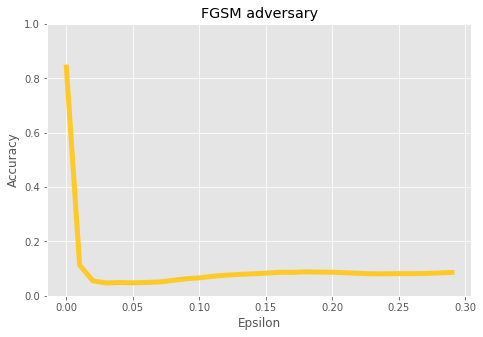

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('FGSM adversary')
    axes.plot(fgsm_accuracy_natural['fgsm_attack_range'], fgsm_accuracy_natural['fgsm_acc'], color='#ffca29', linewidth=5)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()
    plt.savefig('./data/images/quantifyingAdversary.png')

In [ ]:
files.download('./data/images/quantifyingAdversary.png')
files.download('./data/results/fgsm_accuracy_natural.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Adversarial Training (FGSM)

In [ ]:
# Model
net_args = {
    "block": ResidualBlock,
    "channels": train_loader.dataset[0][0].shape[0],
    "layers": [2, 2, 2],
    "num_classes": 10
}
adv_model_fgsm = ResNet(**net_args).to(args.device)

args.adversarial_training = True
args.learning_rate = 0.001

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(adv_model_fgsm.parameters(), lr=args.learning_rate)
scheduler = ReduceLROnPlateau(optimizer, patience = 5)

In [ ]:
# Train the model
train_acc = []
train_adv_acc = []
val_acc = []
val_adv_acc = []

for epoch in range(args.num_epochs):
  adv_model_fgsm.train()
  total = 0
  correct = 0
  correct_adv = 0

  pbar = tqdm(total=len(train_loader), desc='Epoch {}'.format(epoch+1))
  
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    # Train on original images
    outputs, loss = forward_pass(adv_model_fgsm, images, labels, loss_fn, optimizer)
    
    total += labels.size(0)
    pred = torch.max(outputs.data, 1)[1]
    correct += (pred == labels).sum().item()

    if args.adversarial_training:
      # Create adversarial examples
      images_adv = fgsm_attack(images, args.epsilon, images.grad.data)
      
      # Train on adversarial images
      outputs, loss = forward_pass(adv_model_fgsm, images_adv, labels, loss_fn, optimizer)
    
    pred_adv = torch.max(outputs.data, 1)[1]  
    correct_adv += (pred_adv == labels).sum().item()
    
    pbar.update(1)
    
  train_acc.append(correct / total)
  train_adv_acc.append(correct_adv / total)
  
  # Test the model
  adv_model_fgsm.eval()
  total = 0
  correct = 0
  correct_adv = 0
  
  for images, labels in val_loader:
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    outputs = adv_model_fgsm(images)
    
    total += labels.size(0)
    pred = torch.max(outputs.data, 1)[1] # save the prediction of the adversarial sample
    correct += (pred == labels).sum().item()
    
    if args.adversarial_testing:
      val_loss.backward()
      perturbed_images = fgsm_attack(images, args.epsilon, images.grad.data)
      
      outputs = adv_model_fgsm(perturbed_images.to(args.device))
    
    val_loss = loss_fn(outputs, labels)
	  
    pred_adv = torch.max(outputs.data, 1)[1] # save the prediction of the adversarial sample
    correct_adv += (pred_adv == labels).sum().item()

  val_acc.append(correct / total)
  val_adv_acc.append(correct_adv / total)
  
  curr_lr = optimizer.param_groups[0]['lr']
  scheduler.step(train_acc[epoch])
  
  pbar_dict = {'loss':loss.item(),
               'acc':train_acc[epoch],
               'adv_acc':train_adv_acc[epoch],
               'val_loss': val_loss.item(),
               'val_acc':val_acc[epoch],
               'adv_val_acc':val_adv_acc[epoch],
               'LR':curr_lr}

  pbar.set_postfix(pbar_dict)

In [ ]:
# Save hardened models
torch.save(adv_model_fgsm, './data/models/adv_model_fgsm_cifar_resnet18_epochs=50_natural.pt')
# Download hardened models
files.download('./data/models/adv_model_fgsm_cifar_resnet18_epochs=50_natural.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
olympic.evaluate(adv_model_fgsm, val_loader, metrics=['accuracy'],
                 prepare_batch = lambda batch: (batch[0].to(args.device), batch[1].to(args.device)))

{'val_accuracy': 0.7366}

In [ ]:
adv_train_results = {'train_acc': train_acc, 'train_adv_acc': train_adv_acc, 'val_acc': val_acc}

with open('./data/results/adv_train_results.json', 'w') as f:
    json.dump(adv_train_results, f)

No handles with labels found to put in legend.


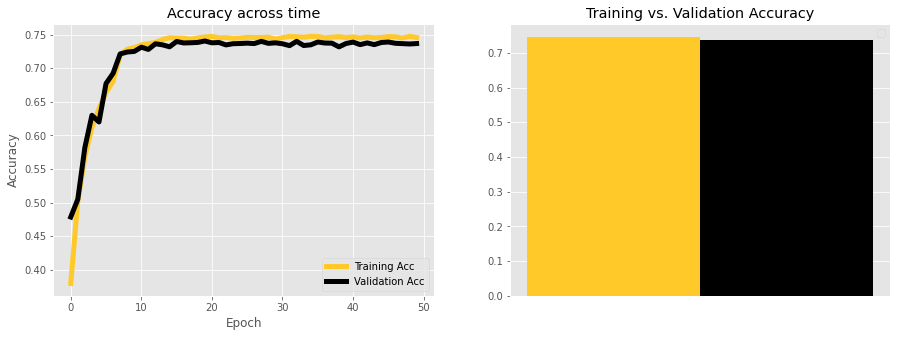

<Figure size 1008x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    
    index = np.arange(1)
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(14,7))
    
    axes[0].set_title('Accuracy across time')
    axes[0].plot(adv_train_results['train_acc'], label='Training Acc', color='#ffca29', linewidth=5)
    # axes[0].plot(adv_train_results['train_adv_acc'], label='Training Adversarial Acc', color='#be9430', linewidth=5)
    axes[0].plot(adv_train_results['val_acc'], label='Validation Acc', color='black', linewidth=5)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend() 

    axes[1].set_title('Training vs. Validation Accuracy')
    axes[1].bar(index, adv_train_results['train_acc'][-1], 0.2, color='#ffca29')
    axes[1].bar(index+0.2, adv_train_results['val_acc'][-1], 0.2, color='black')
    axes[1].set_xticks([])
    axes[1].legend()
    
    plt.show()
    plt.savefig('./data/images/adversarialTraining.png')

In [ ]:
files.download('./data/images/adversarialTraining.png')
files.download('./data/results/adv_train_results.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load hardened models
adv_model_fgsm = torch.load('./data/models/adv_model_fgsm_cifar_resnet18_epochs=50_natural.pt')

In [ ]:
olympic.evaluate(adv_model_fgsm, val_loader, metrics=['accuracy'],
                 prepare_batch = lambda batch: (batch[0].to(args.device), batch[1].to(args.device)))

{'val_accuracy': 0.7366}

## Natural vs. Robust Accuracy

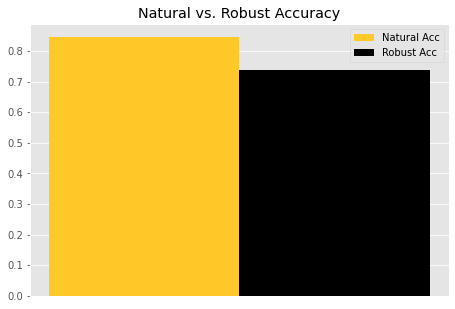

<Figure size 1008x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    
    index = np.arange(1)
    fig, axes = plt.subplots(1, 1, figsize=(7.5,5))
    plt.figure(figsize=(14,7))
    
    axes.set_title('Natural vs. Robust Accuracy')
    axes.bar(index, train_results['val_acc'], 0.2, color='#ffca29', label='Natural Acc')
    axes.bar(index+0.2, adv_train_results['val_acc'][-1], 0.2, color='black', label='Robust Acc')
    axes.set_xticks([])
    axes.legend()
    
    plt.show()
    plt.savefig('./data/images/compareAccuracy.png')

In [ ]:
files.download('./data/images/compareAccuracy.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluate robust model

In [ ]:
fgsm_attack_range = np.arange(0.0, 0.3, 0.01)
fgsm_acc = []
for eps in fgsm_attack_range:
    fgsm_acc.append(evaluate_against_adversary(adv_model_fgsm, val_loader, k=1, eps=eps, step=1, norm='fgsm', device=args.device))

In [ ]:
fgsm_accuracy_robust = {'fgsm_attack_range': list(fgsm_attack_range), 'fgsm_acc': fgsm_acc}

with open('./data/results/fgsm_accuracy_robust.json', 'w') as f:
    json.dump(fgsm_accuracy_robust, f)

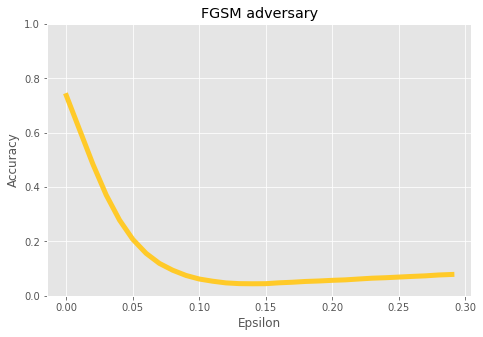

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('FGSM adversary')
    axes.plot(fgsm_accuracy_robust['fgsm_attack_range'], fgsm_accuracy_robust['fgsm_acc'], color='#ffca29', linewidth=5)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()
    plt.savefig('./data/images/evalutingRobustness.png')

In [ ]:
files.download('./data/images/evalutingRobustness.png')
files.download('./data/results/fgsm_accuracy_robust.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Attack with Iterated-FGSM

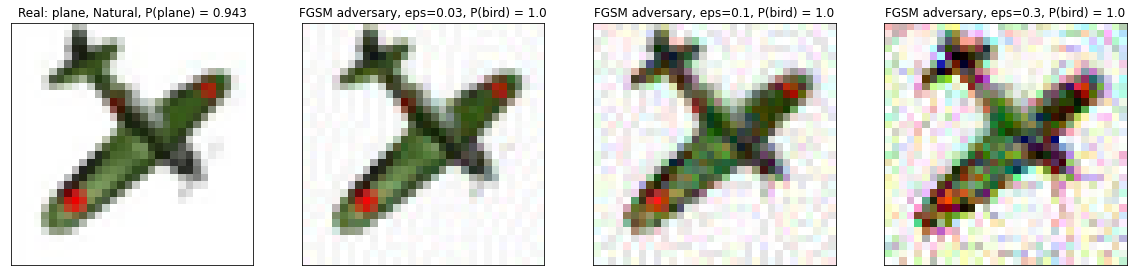

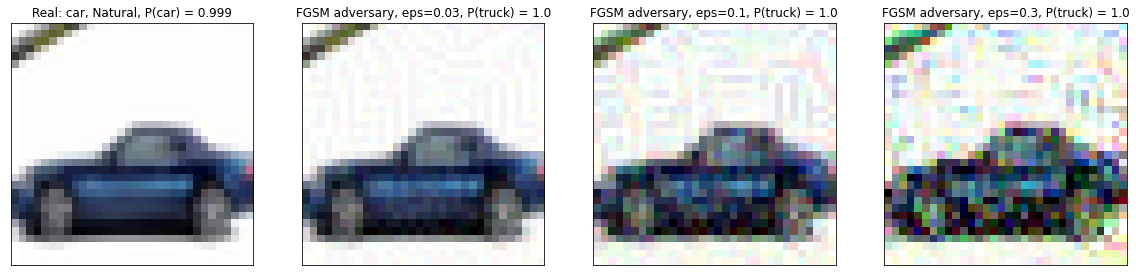

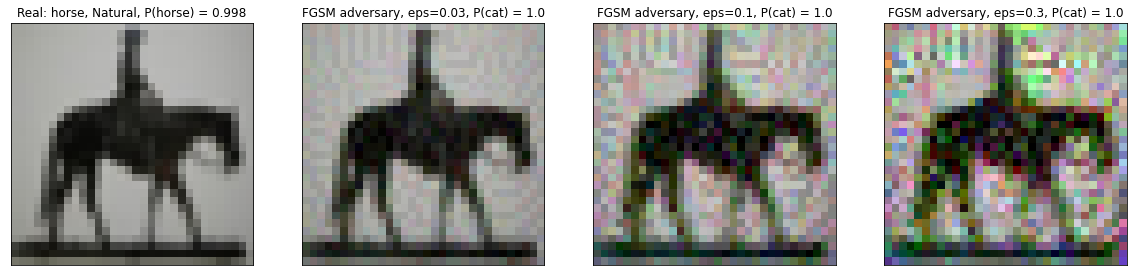

In [ ]:
visualise_adversarial_examples_ifgsm(model, *val[98], args.device)
visualise_adversarial_examples_ifgsm(model, *val[105], args.device)
visualise_adversarial_examples_ifgsm(model, *val[288], args.device)

## Quantifying adversarial accuracy with Iterated-FGSM

In [ ]:
iter_fgsm_attack_range = np.arange(0.0, 0.3, 0.01)
iter_fgsm_acc = []
for eps in iter_fgsm_attack_range:
    iter_fgsm_acc.append(evaluate_against_adversary(adv_model_fgsm, val_loader, k=80, eps=eps, step=0.01, norm='i-fgsm', device=args.device))

In [ ]:
iter_fgsm_accuracy_robust = {'iter_fgsm_attack_range': list(iter_fgsm_attack_range), 'iter_fgsm_acc': iter_fgsm_acc}

with open('./data/results/iter_fgsm_accuracy_robust.json', 'w') as f:
    json.dump(iter_fgsm_accuracy_robust, f)

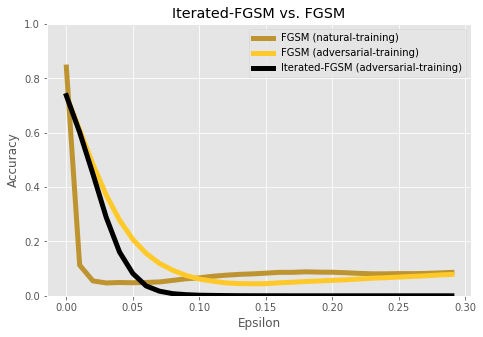

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('Iterated-FGSM vs. FGSM')
    axes.plot(fgsm_accuracy_natural['fgsm_attack_range'], fgsm_accuracy_natural['fgsm_acc'], label='FGSM (natural-training)', color='#be9430', linewidth=5)
    axes.plot(fgsm_accuracy_robust['fgsm_attack_range'], fgsm_accuracy_robust['fgsm_acc'], label='FGSM (adversarial-training)', color='#ffca29', linewidth=5)
    axes.plot(iter_fgsm_accuracy_robust['iter_fgsm_attack_range'], iter_fgsm_accuracy_robust['iter_fgsm_acc'], label='Iterated-FGSM (adversarial-training)', color='black', linewidth=5)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    axes.legend()
    
    plt.show()
    plt.savefig('./data/images/iter_fgsm_accuracy_robust.png')

In [ ]:
files.download('./data/images/iter_fgsm_accuracy_robust.png')
files.download('./data/results/iter_fgsm_accuracy_robust.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('utils.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Troubleshooting

## Original training

Epoch [1/100], Training Loss: 1.9469 Training Accuracy: 20.134 Testing Accuracy: 51.57 Testing Adversarial Accuracy: 20.08


Epoch [2/100], Training Loss: 1.9563 Training Accuracy: 21.768 Testing Accuracy: 53.72 Testing Adversarial Accuracy: 18.84


Epoch [3/100], Training Loss: 2.2929 Training Accuracy: 22.776 Testing Accuracy: 56.71 Testing Adversarial Accuracy: 23.08


Epoch [4/100], Training Loss: 1.8072 Training Accuracy: 23.814 Testing Accuracy: 60.86 Testing Adversarial Accuracy: 22.83


Epoch [5/100], Training Loss: 2.1153 Training Accuracy: 24.912 Testing Accuracy: 62.51 Testing Adversarial Accuracy: 23.94


Epoch [6/100], Training Loss: 2.2384 Training Accuracy: 25.756 Testing Accuracy: 63.71 Testing Adversarial Accuracy: 25.49


Epoch [7/100], Training Loss: 1.6561 Training Accuracy: 27.392 Testing Accuracy: 61.83 Testing Adversarial Accuracy: 29.48


Epoch [8/100], Training Loss: 1.2669 Training Accuracy: 46.764 Testing Accuracy: 65.46 Testing Adversarial Accuracy: 31.18


Epoch [9/100], Training Loss: 1.0087 Training Accuracy: 61.146 Testing Accuracy: 67.95 Testing Adversarial Accuracy: 39.09


Epoch [10/100], Training Loss: 0.7808 Training Accuracy: 70.712 Testing Accuracy: 66.09 Testing Adversarial Accuracy: 46.21


Epoch [11/100], Training Loss: 0.9295 Training Accuracy: 76.434 Testing Accuracy: 70.27 Testing Adversarial Accuracy: 49.58


Epoch [12/100], Training Loss: 0.7606 Training Accuracy: 78.832 Testing Accuracy: 67.97 Testing Adversarial Accuracy: 47.67


Epoch [13/100], Training Loss: 0.5414 Training Accuracy: 81.242 Testing Accuracy: 68.49 Testing Adversarial Accuracy: 54.79


Epoch [14/100], Training Loss: 0.3783 Training Accuracy: 84.124 Testing Accuracy: 70.74 Testing Adversarial Accuracy: 66.43


Epoch [15/100], Training Loss: 0.5982 Training Accuracy: 87.426 Testing Accuracy: 70.34 Testing Adversarial Accuracy: 72.57


Epoch [16/100], Training Loss: 0.2423 Training Accuracy: 90.464 Testing Accuracy: 75.59 Testing Adversarial Accuracy: 70.74


Epoch [17/100], Training Loss: 0.2033 Training Accuracy: 92.93 Testing Accuracy: 74.36 Testing Adversarial Accuracy: 81.64


Epoch [18/100], Training Loss: 0.1362 Training Accuracy: 94.054 Testing Accuracy: 74.89 Testing Adversarial Accuracy: 84.27


Epoch [19/100], Training Loss: 0.2283 Training Accuracy: 94.822 Testing Accuracy: 77.69 Testing Adversarial Accuracy: 83.06


Epoch [20/100], Training Loss: 0.1884 Training Accuracy: 95.064 Testing Accuracy: 76.6 Testing Adversarial Accuracy: 83.49


Epoch [21/100], Training Loss: 0.2165 Training Accuracy: 96.498 Testing Accuracy: 79.58 Testing Adversarial Accuracy: 84.98


Epoch [22/100], Training Loss: 0.0821 Training Accuracy: 96.57 Testing Accuracy: 77.79 Testing Adversarial Accuracy: 84.84


Epoch [23/100], Training Loss: 0.1113 Training Accuracy: 96.87 Testing Accuracy: 80.79 Testing Adversarial Accuracy: 84.03


Epoch [24/100], Training Loss: 0.1039 Training Accuracy: 96.908 Testing Accuracy: 79.26 Testing Adversarial Accuracy: 82.34


Epoch [25/100], Training Loss: 0.2244 Training Accuracy: 96.928 Testing Accuracy: 78.81 Testing Adversarial Accuracy: 80.66


Epoch [26/100], Training Loss: 0.0597 Training Accuracy: 97.008 Testing Accuracy: 78.64 Testing Adversarial Accuracy: 81.23


Epoch [27/100], Training Loss: 0.1364 Training Accuracy: 97.11 Testing Accuracy: 78.85 Testing Adversarial Accuracy: 79.22


Epoch [28/100], Training Loss: 0.0530 Training Accuracy: 97.186 Testing Accuracy: 79.92 Testing Adversarial Accuracy: 82.87


Epoch [29/100], Training Loss: 0.0215 Training Accuracy: 97.166 Testing Accuracy: 80.31 Testing Adversarial Accuracy: 80.08


Epoch [30/100], Training Loss: 0.0329 Training Accuracy: 97.234 Testing Accuracy: 80.24 Testing Adversarial Accuracy: 79.38


Epoch [31/100], Training Loss: 0.1104 Training Accuracy: 97.294 Testing Accuracy: 78.78 Testing Adversarial Accuracy: 80.86


Epoch [32/100], Training Loss: 0.1004 Training Accuracy: 97.36 Testing Accuracy: 78.12 Testing Adversarial Accuracy: 78.66


Epoch [33/100], Training Loss: 0.0859 Training Accuracy: 97.378 Testing Accuracy: 80.0 Testing Adversarial Accuracy: 78.18


Epoch [34/100], Training Loss: 0.0983 Training Accuracy: 97.388 Testing Accuracy: 79.8 Testing Adversarial Accuracy: 76.48


Epoch [35/100], Training Loss: 0.1056 Training Accuracy: 97.568 Testing Accuracy: 78.4 Testing Adversarial Accuracy: 77.3


Epoch [36/100], Training Loss: 0.0784 Training Accuracy: 97.458 Testing Accuracy: 79.83 Testing Adversarial Accuracy: 74.34


Epoch [37/100], Training Loss: 0.0333 Training Accuracy: 97.496 Testing Accuracy: 78.96 Testing Adversarial Accuracy: 76.24


Epoch [38/100], Training Loss: 0.0482 Training Accuracy: 97.598 Testing Accuracy: 78.6 Testing Adversarial Accuracy: 73.94


Epoch [39/100], Training Loss: 0.2932 Training Accuracy: 97.644 Testing Accuracy: 78.63 Testing Adversarial Accuracy: 70.54


Epoch [40/100], Training Loss: 0.0505 Training Accuracy: 97.76 Testing Accuracy: 79.03 Testing Adversarial Accuracy: 75.53


Epoch [41/100], Training Loss: 0.0568 Training Accuracy: 97.93 Testing Accuracy: 80.51 Testing Adversarial Accuracy: 74.13


Epoch [42/100], Training Loss: 0.0379 Training Accuracy: 97.998 Testing Accuracy: 81.41 Testing Adversarial Accuracy: 72.53


Epoch [43/100], Training Loss: 0.0736 Training Accuracy: 97.974 Testing Accuracy: 80.56 Testing Adversarial Accuracy: 73.09


Epoch [44/100], Training Loss: 0.1083 Training Accuracy: 98.044 Testing Accuracy: 80.49 Testing Adversarial Accuracy: 74.47


Epoch [45/100], Training Loss: 0.0397 Training Accuracy: 97.982 Testing Accuracy: 78.28 Testing Adversarial Accuracy: 73.64


Epoch [46/100], Training Loss: 0.0650 Training Accuracy: 97.992 Testing Accuracy: 79.67 Testing Adversarial Accuracy: 72.08


Epoch [47/100], Training Loss: 0.1687 Training Accuracy: 98.126 Testing Accuracy: 79.57 Testing Adversarial Accuracy: 73.45


Epoch [48/100], Training Loss: 0.1372 Training Accuracy: 98.036 Testing Accuracy: 79.96 Testing Adversarial Accuracy: 72.2


Epoch [49/100], Training Loss: 0.1836 Training Accuracy: 98.134 Testing Accuracy: 78.99 Testing Adversarial Accuracy: 73.03


Epoch [50/100], Training Loss: 0.0111 Training Accuracy: 97.964 Testing Accuracy: 79.53 Testing Adversarial Accuracy: 72.42


Epoch [51/100], Training Loss: 0.1233 Training Accuracy: 98.142 Testing Accuracy: 78.76 Testing Adversarial Accuracy: 73.66


Epoch [52/100], Training Loss: 0.0513 Training Accuracy: 98.1 Testing Accuracy: 80.06 Testing Adversarial Accuracy: 71.9


Epoch [53/100], Training Loss: 0.0637 Training Accuracy: 98.076 Testing Accuracy: 79.53 Testing Adversarial Accuracy: 71.35


Epoch [54/100], Training Loss: 0.1368 Training Accuracy: 98.132 Testing Accuracy: 77.58 Testing Adversarial Accuracy: 74.17


Epoch [55/100], Training Loss: 0.1419 Training Accuracy: 98.08 Testing Accuracy: 80.19 Testing Adversarial Accuracy: 71.95


Epoch [56/100], Training Loss: 0.0762 Training Accuracy: 98.006 Testing Accuracy: 80.17 Testing Adversarial Accuracy: 71.86


Epoch [57/100], Training Loss: 0.0781 Training Accuracy: 98.148 Testing Accuracy: 79.58 Testing Adversarial Accuracy: 70.69


Epoch [58/100], Training Loss: 0.0409 Training Accuracy: 98.11 Testing Accuracy: 80.23 Testing Adversarial Accuracy: 73.25


Epoch [59/100], Training Loss: 0.1049 Training Accuracy: 98.166 Testing Accuracy: 80.78 Testing Adversarial Accuracy: 73.42


Epoch [60/100], Training Loss: 0.0323 Training Accuracy: 98.186 Testing Accuracy: 79.31 Testing Adversarial Accuracy: 71.85


Epoch [61/100], Training Loss: 0.1664 Training Accuracy: 98.164 Testing Accuracy: 80.95 Testing Adversarial Accuracy: 71.06


Epoch [62/100], Training Loss: 0.0741 Training Accuracy: 98.218 Testing Accuracy: 79.22 Testing Adversarial Accuracy: 70.45


Epoch [63/100], Training Loss: 0.1373 Training Accuracy: 98.28 Testing Accuracy: 79.49 Testing Adversarial Accuracy: 72.49


Epoch [64/100], Training Loss: 0.0313 Training Accuracy: 98.188 Testing Accuracy: 80.65 Testing Adversarial Accuracy: 70.62


Epoch [65/100], Training Loss: 0.0352 Training Accuracy: 98.232 Testing Accuracy: 79.67 Testing Adversarial Accuracy: 69.85


Epoch [66/100], Training Loss: 0.1218 Training Accuracy: 98.314 Testing Accuracy: 80.49 Testing Adversarial Accuracy: 70.99


Epoch [67/100], Training Loss: 0.0282 Training Accuracy: 98.208 Testing Accuracy: 79.8 Testing Adversarial Accuracy: 71.27


Epoch [68/100], Training Loss: 0.0988 Training Accuracy: 98.286 Testing Accuracy: 80.33 Testing Adversarial Accuracy: 70.4


Epoch [69/100], Training Loss: 0.0423 Training Accuracy: 98.366 Testing Accuracy: 79.88 Testing Adversarial Accuracy: 72.15


Epoch [70/100], Training Loss: 0.0485 Training Accuracy: 98.252 Testing Accuracy: 80.93 Testing Adversarial Accuracy: 69.96


Epoch [71/100], Training Loss: 0.0855 Training Accuracy: 98.298 Testing Accuracy: 81.29 Testing Adversarial Accuracy: 70.5


Epoch [72/100], Training Loss: 0.0765 Training Accuracy: 98.318 Testing Accuracy: 81.13 Testing Adversarial Accuracy: 69.09


Epoch [73/100], Training Loss: 0.0712 Training Accuracy: 98.27 Testing Accuracy: 80.09 Testing Adversarial Accuracy: 69.88


Epoch [74/100], Training Loss: 0.0137 Training Accuracy: 98.218 Testing Accuracy: 79.44 Testing Adversarial Accuracy: 68.03


Epoch [75/100], Training Loss: 0.0612 Training Accuracy: 98.254 Testing Accuracy: 80.6 Testing Adversarial Accuracy: 69.43


Epoch [76/100], Training Loss: 0.0352 Training Accuracy: 98.226 Testing Accuracy: 79.25 Testing Adversarial Accuracy: 70.71


Epoch [77/100], Training Loss: 0.1216 Training Accuracy: 98.29 Testing Accuracy: 79.53 Testing Adversarial Accuracy: 70.3


Epoch [78/100], Training Loss: 0.0575 Training Accuracy: 98.262 Testing Accuracy: 80.92 Testing Adversarial Accuracy: 70.22


Epoch [79/100], Training Loss: 0.0628 Training Accuracy: 98.242 Testing Accuracy: 80.44 Testing Adversarial Accuracy: 69.96


Epoch [80/100], Training Loss: 0.0213 Training Accuracy: 98.24 Testing Accuracy: 80.52 Testing Adversarial Accuracy: 70.0


Epoch [81/100], Training Loss: 0.0602 Training Accuracy: 98.23 Testing Accuracy: 80.98 Testing Adversarial Accuracy: 70.16


Epoch [82/100], Training Loss: 0.0659 Training Accuracy: 98.298 Testing Accuracy: 80.68 Testing Adversarial Accuracy: 69.17


Epoch [83/100], Training Loss: 0.0454 Training Accuracy: 98.356 Testing Accuracy: 80.95 Testing Adversarial Accuracy: 70.93


Epoch [84/100], Training Loss: 0.0583 Training Accuracy: 98.348 Testing Accuracy: 80.47 Testing Adversarial Accuracy: 69.05


Epoch [85/100], Training Loss: 0.0961 Training Accuracy: 98.394 Testing Accuracy: 80.87 Testing Adversarial Accuracy: 71.01


Epoch [86/100], Training Loss: 0.0641 Training Accuracy: 98.324 Testing Accuracy: 81.11 Testing Adversarial Accuracy: 70.02


Epoch [87/100], Training Loss: 0.0694 Training Accuracy: 98.33 Testing Accuracy: 80.93 Testing Adversarial Accuracy: 69.3


Epoch [88/100], Training Loss: 0.0131 Training Accuracy: 98.272 Testing Accuracy: 80.59 Testing Adversarial Accuracy: 68.12


Epoch [89/100], Training Loss: 0.0231 Training Accuracy: 98.41 Testing Accuracy: 81.14 Testing Adversarial Accuracy: 68.23


Epoch [90/100], Training Loss: 0.0460 Training Accuracy: 98.37 Testing Accuracy: 80.32 Testing Adversarial Accuracy: 69.52


Epoch [91/100], Training Loss: 0.1048 Training Accuracy: 98.32 Testing Accuracy: 80.99 Testing Adversarial Accuracy: 69.25


Epoch [92/100], Training Loss: 0.0294 Training Accuracy: 98.306 Testing Accuracy: 80.11 Testing Adversarial Accuracy: 69.02


Epoch [93/100], Training Loss: 0.0197 Training Accuracy: 98.322 Testing Accuracy: 80.17 Testing Adversarial Accuracy: 68.92


Epoch [94/100], Training Loss: 0.1136 Training Accuracy: 98.208 Testing Accuracy: 80.8 Testing Adversarial Accuracy: 68.63


Epoch [95/100], Training Loss: 0.0169 Training Accuracy: 98.286 Testing Accuracy: 80.69 Testing Adversarial Accuracy: 68.73


Epoch [96/100], Training Loss: 0.1452 Training Accuracy: 98.308 Testing Accuracy: 80.15 Testing Adversarial Accuracy: 69.45


Epoch [97/100], Training Loss: 0.0313 Training Accuracy: 98.348 Testing Accuracy: 80.99 Testing Adversarial Accuracy: 68.4


Epoch [98/100], Training Loss: 0.0387 Training Accuracy: 98.252 Testing Accuracy: 80.76 Testing Adversarial Accuracy: 68.35


Epoch [99/100], Training Loss: 0.0491 Training Accuracy: 98.35 Testing Accuracy: 81.39 Testing Adversarial Accuracy: 67.31


Epoch [100/100], Training Loss: 0.0412 Training Accuracy: 98.332 Testing Accuracy: 80.51 Testing Adversarial Accuracy: 69.03


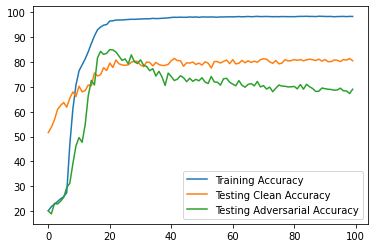

In [ ]:
# Adversarial Training, Adversarial Testing - Model Zero Grad
# Train the model
epochs_l = []
training_accuracy_l = []
testing_accuracy_l = []
testing_accuracy_adv_l = []
total_step = len(train_loader)
curr_lr = args.learning_rate

for epoch in range(args.num_epochs):
  model.train()
  epochs_l.append(epoch+1)
  total_train = 0
  correct_train = 0

  train_tqdm = tqdm(range(len(train_loader.dataset)))
  
  for i, (images_train, labels_train) in enumerate(train_loader):
    images_train, labels_train = images_train.to(args.device), labels_train.to(args.device)
    images_train.requires_grad = True
    
    # Train on original images_train
    # Forward pass
    optimizer.zero_grad()
    outputs_train = model(images_train)
    loss_train = criterion(outputs_train, labels_train)
    # Backward and optimize
    loss_train.backward()
    optimizer.step()
    
    if args.adversarial_training:
      # Create adversarial examples
      data_grad_train = images_train.grad.data
      adv_images_train = fgsm_attack(images_train, args.epsilon, data_grad_train)
      
      # Train on adversarial images_train
      # Forward pass
      optimizer.zero_grad()
      outputs_train = model(adv_images_train)
      loss_train = criterion(outputs_train, labels_train)
      # Backward and optimize
      loss_train.backward()
      optimizer.step()
    
    total_train += labels_train.size(0)
    predicted_train = torch.max(outputs_train.data, 1)[1]  
    correct_train += (predicted_train == labels_train).sum().item()
    
    train_tqdm.update(len(images_train))
    
  training_accuracy_l.append(100 * correct_train / total_train)
  
  # Decay earning rate
  if (epoch+1) % 20 == 0:
    curr_lr /= 3
    update_lr(optimizer, curr_lr)

  # Test the model
  model.eval()
  # with torch.no_grad():
  correct_test_clean = 0
  total_test_clean = 0
  correct_test_adv = 0
  total_test_adv = 0
  for images_test, labels_test in test_loader:
    images_test, labels_test = images_test.to(args.device), labels_test.to(args.device)
    images_test.requires_grad = True
    
    output_test = model(images_test)
    
    pred_test_clean = torch.max(output_test.data, 1)[1] # save the pred_test_cleaniction of the adversarial sample
    total_test_clean += labels_test.size(0)
    correct_test_clean += (pred_test_clean == labels_test).sum().item()  
    
    if args.adversarial_testing:
      loss_test_adv = criterion(output_test, labels_test)
      model.zero_grad()
      loss_test_adv.backward()
      data_grad_test_adv = images_test.grad.data
      perturbed_images_test = fgsm_attack(images_test, args.epsilon, data_grad_test_adv)
      output_test_adv = model(perturbed_images_test.to(args.device))
    
    pred_test_adv = torch.max(output_test_adv.data, 1)[1] # save the pred_test_adviction of the adversarial sample
    total_test_adv += labels_test.size(0)
    correct_test_adv += (pred_test_adv == labels_test).sum().item()  
    
  testing_accuracy_l.append(100 * correct_test_clean / total_test_clean)
  testing_accuracy_adv_l.append(100 * correct_test_adv / total_test_adv)
  
  print ("Epoch [{}/{}], Training Loss: {:.4f} Training Accuracy: {} Testing Accuracy: {} Testing Adversarial Accuracy: {}"
  .format(epoch+1, args.num_epochs, loss_train.item(), training_accuracy_l[epoch], testing_accuracy_l[epoch], testing_accuracy_adv_l[epoch]))


# plot lines 
results_plot = plt.figure()
plt.plot(training_accuracy_l, label = "Training Accuracy") 
plt.plot(testing_accuracy_l, label = "Testing Clean Accuracy") 
plt.plot(testing_accuracy_adv_l, label = "Testing Adversarial Accuracy") 
plt.legend() 
plt.show()
results_plot.show()


Epoch [1/100], Training Loss: 2.1512 Training Accuracy: 21.332 Testing Accuracy: 53.95 Testing Adversarial Accuracy: 20.01
Epoch [2/100], Training Loss: 1.8932 Training Accuracy: 22.698 Testing Accuracy: 58.55 Testing Adversarial Accuracy: 21.74
Epoch [3/100], Training Loss: 1.8933 Training Accuracy: 23.706 Testing Accuracy: 59.26 Testing Adversarial Accuracy: 21.52
Epoch [4/100], Training Loss: 1.9397 Training Accuracy: 24.44 Testing Accuracy: 61.37 Testing Adversarial Accuracy: 23.15
Epoch [5/100], Training Loss: 1.8000 Training Accuracy: 25.558 Testing Accuracy: 63.65 Testing Adversarial Accuracy: 24.43
Epoch [6/100], Training Loss: 1.4482 Training Accuracy: 34.272 Testing Accuracy: 64.68 Testing Adversarial Accuracy: 36.56
Epoch [7/100], Training Loss: 1.1693 Training Accuracy: 54.836 Testing Accuracy: 55.47 Testing Adversarial Accuracy: 55.32
Epoch [8/100], Training Loss: 0.6427 Training Accuracy: 70.882 Testing Accuracy: 62.05 Testing Adversarial Accuracy: 58.31
Epoch [9/100], Tr

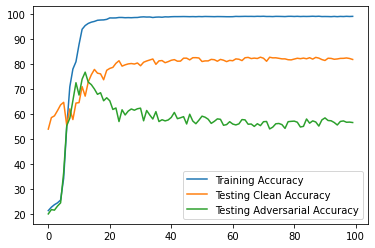

In [ ]:
# Adversarial Training, Adversarial Testing - Model Zero Grad
# Train the model
epochs_l = []
training_accuracy_l = []
testing_accuracy_l = []
testing_accuracy_adv_l = []
total_step = len(train_loader)
curr_lr = args.learning_rate

for epoch in range(args.num_epochs):
  model.train()
  epochs_l.append(epoch+1)
  total_train = 0
  correct_train = 0
  
  for i, (images_train, labels_train) in enumerate(train_loader):
    images_train, labels_train = images_train.to(args.device), labels_train.to(args.device)
    images_train.requires_grad = True
    
    # Train on original images_train
    # Forward pass
    optimizer.zero_grad()
    outputs_train = model(images_train)
    loss_train = criterion(outputs_train, labels_train)
    # Backward and optimize
    loss_train.backward()
    optimizer.step()
    
    if args.adversarial_training:
      # Create adversarial examples
      data_grad_train = images_train.grad.data
      adv_images_train = fgsm_attack(images_train, args.epsilon, data_grad_train)
      
      # Train on adversarial images_train
      # Forward pass
      optimizer.zero_grad()
      outputs_train = model(adv_images_train)
      loss_train = criterion(outputs_train, labels_train)
      # Backward and optimize
      loss_train.backward()
      optimizer.step()
    
    total_train += labels_train.size(0)
    predicted_train = torch.max(outputs_train.data, 1)[1]  
    correct_train += (predicted_train == labels_train).sum().item()
    
  training_accuracy_l.append(100 * correct_train / total_train)
  
  # Decay earning rate
  if (epoch+1) % 20 == 0:
    curr_lr /= 3
    update_lr(optimizer, curr_lr)

  # Test the model
  model.eval()
  # with torch.no_grad():
  correct_test_clean = 0
  total_test_clean = 0
  correct_test_adv = 0
  total_test_adv = 0
  for images_test, labels_test in test_loader:
    images_test, labels_test = images_test.to(args.device), labels_test.to(args.device)
    images_test.requires_grad = True
    
    output_test = model(images_test)
    
    pred_test_clean = torch.max(output_test.data, 1)[1] # save the pred_test_cleaniction of the adversarial sample
    total_test_clean += labels_test.size(0)
    correct_test_clean += (pred_test_clean == labels_test).sum().item()  
    
    if args.adversarial_testing:
      loss_test_adv = criterion(output_test, labels_test)
      model.zero_grad()
      loss_test_adv.backward()
      data_grad_test_adv = images_test.grad.data
      perturbed_images_test = fgsm_attack(images_test, args.epsilon, data_grad_test_adv)
      output_test_adv = model(perturbed_images_test.to(args.device))
    
    pred_test_adv = torch.max(output_test_adv.data, 1)[1] # save the pred_test_adviction of the adversarial sample
    total_test_adv += labels_test.size(0)
    correct_test_adv += (pred_test_adv == labels_test).sum().item()  
    
  testing_accuracy_l.append(100 * correct_test_clean / total_test_clean)
  testing_accuracy_adv_l.append(100 * correct_test_adv / total_test_adv)
  
  print ("Epoch [{}/{}], Training Loss: {:.4f} Training Accuracy: {} Testing Accuracy: {} Testing Adversarial Accuracy: {}"
  .format(epoch+1, args.num_epochs, loss_train.item(), training_accuracy_l[epoch], testing_accuracy_l[epoch], testing_accuracy_adv_l[epoch]))


# plot lines 
results_plot = plt.figure()
plt.plot(training_accuracy_l, label = "Training Accuracy") 
plt.plot(testing_accuracy_l, label = "Testing Clean Accuracy") 
plt.plot(testing_accuracy_adv_l, label = "Testing Adversarial Accuracy") 
plt.legend() 
plt.show()
results_plot.show()


Epoch [1/50], Training Loss: 2.1137 Training Accuracy: 16.912 Testing Accuracy: 18.69
Epoch [2/50], Training Loss: 1.9329 Training Accuracy: 19.684 Testing Accuracy: 19.06
Epoch [3/50], Training Loss: 2.0690 Training Accuracy: 21.158 Testing Accuracy: 19.16
Epoch [4/50], Training Loss: 1.8634 Training Accuracy: 22.298 Testing Accuracy: 20.48
Epoch [5/50], Training Loss: 2.0937 Training Accuracy: 23.33 Testing Accuracy: 22.54
Epoch [6/50], Training Loss: 1.9220 Training Accuracy: 24.202 Testing Accuracy: 23.36
Epoch [7/50], Training Loss: 1.3933 Training Accuracy: 32.856 Testing Accuracy: 31.1
Epoch [8/50], Training Loss: 0.4216 Training Accuracy: 72.914 Testing Accuracy: 42.86
Epoch [9/50], Training Loss: 0.5111 Training Accuracy: 84.478 Testing Accuracy: 53.42
Epoch [10/50], Training Loss: 0.3037 Training Accuracy: 88.08 Testing Accuracy: 57.57
Epoch [11/50], Training Loss: 0.1728 Training Accuracy: 89.502 Testing Accuracy: 59.09
Epoch [12/50], Training Loss: 0.2468 Training Accuracy:

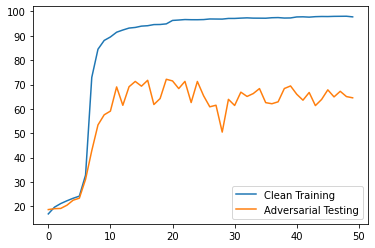

<Figure size 432x288 with 0 Axes>

In [ ]:
# Adversarial Training, Adversarial Testing - Model Zero Grad
# Train the model
epochs_l = []
training_accuracy_l = []
training_adv_accuracy_l = []
testing_accuracy_l = []
total_step = len(train_loader)
curr_lr = args.learning_rate

for epoch in range(args.num_epochs):
  model.train()
  epochs_l.append(epoch+1)
  correct = 0
  total = 0
  correct_adv = 0
  total_adv = 0
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    # Train on original images
    # Forward pass
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    # Backward and optimize
    loss.backward()
    optimizer.step()
    
    if args.adversarial_training:
      # Create adversarial examples
      data_grad = images.grad.data
      adv_images = fgsm_attack(images, args.epsilon, data_grad)
      
      # Train on adversarial images
      # Forward pass
      optimizer.zero_grad()
      outputs = model(adv_images)
      loss = criterion(outputs, labels)
      # Backward and optimize
      loss.backward()
      optimizer.step()
    
    total += labels.size(0)
    predicted_training = torch.max(outputs.data, 1)[1]  
    correct += (predicted_training == labels).sum().item()
    
  training_accuracy_l.append(100 * correct / total)
  
  # Decay earning rate
  if (epoch+1) % 20 == 0:
    curr_lr /= 3
    update_lr(optimizer, curr_lr)

  # Test the model
  model.eval()
  # with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    output = model(images.to(args.device))
    
    if args.adversarial_testing:
      loss_test = criterion(output, labels.to(args.device))
      model.zero_grad()
      loss_test.backward()
      data_grad = images.grad.data
      perturbed_images = fgsm_attack(images, args.epsilon, data_grad)
      output = model(perturbed_images.to(args.device))
    
    pred = torch.max(output.data, 1)[1] # save the prediction of the adversarial sample
    total += labels.size(0)
    correct += (pred == labels).sum().item()  
    
  testing_accuracy_l.append(100 * correct / total)
  print ("Epoch [{}/{}], Training Loss: {:.4f} Training Accuracy: {} Testing Accuracy: {}"
  .format(epoch+1, args.num_epochs, loss.item(), training_accuracy_l[epoch], testing_accuracy_l[epoch]))


# plot lines 
results_plot = plt.figure()
plt.plot(training_accuracy_l, label = "Training Accuracy") 
plt.plot(testing_accuracy_l, label = "Testing Accuracy") 
plt.legend() 
plt.show()
results_plot.show()
results_plot.savefig('AdversarialAdversarial.png')


## Slightly modified training

In [ ]:
# Train the model
train_acc = []
val_acc = []

for epoch in range(args.num_epochs):
  model.train()
  total = 0
  correct = 0

  pbar = tqdm(total=len(train_loader), desc='Epoch {}'.format(epoch+1))
  
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    # Train on original images
    # Forward pass
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    # Backward and optimize
    loss.backward()
    optimizer.step()
    
    if args.adversarial_training:
      # Create adversarial examples
      data_grad_train = images.grad.data
      images_adv = fgsm_attack(images, args.epsilon, data_grad_train)
      
      # Train on adversarial images
      # Forward pass
      optimizer.zero_grad()
      outputs = model(images_adv)
      loss = loss_fn(outputs, labels)
      # Backward and optimize
      loss.backward()
      optimizer.step()
    
    pred = torch.max(outputs.data, 1)[1]  
    total += labels.size(0)
    correct += (pred == labels).sum().item()
    
    pbar.update(1)
    
  train_acc.append(correct / total)
  
  # Test the model
  model.eval()
  total = 0
  correct = 0
  correct_adv = 0
  
  for images, labels in val_loader:
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    outputs = model(images)
    val_loss = loss_fn(outputs, labels)
    
    if args.adversarial_testing:
      val_loss.backward()
      perturbed_images = fgsm_attack(images, args.epsilon, images.grad.data)
      outputs = model(perturbed_images.to(args.device))
      val_loss = loss_fn(outputs, labels)
	  
    pred = torch.max(outputs.data, 1)[1] # save the prediction of the adversarial sample
    total += labels.size(0)
    correct += (pred == labels).sum().item()

  val_acc.append(correct / total)
  
  curr_lr = optimizer.param_groups[0]['lr']
  scheduler.step(train_acc[epoch])
  
  pbar_dict = {'loss':loss.item(),
               'acc':train_acc[epoch],
               'val_loss': val_loss.item(),
               'val_acc':val_acc[epoch],
               'LR':curr_lr}

  pbar.set_postfix(pbar_dict)

In [ ]:
# Train the model
train_acc = []
val_acc = []
val_adv_acc = []

for epoch in range(args.num_epochs):
  model.train()
  total = 0
  correct = 0

  pbar = tqdm(total=len(train_loader), desc='Epoch {}'.format(epoch+1))
  
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    # Train on original images
    # Forward pass
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    # Backward and optimize
    loss.backward()
    optimizer.step()
    
    if args.adversarial_training:
      # Create adversarial examples
      data_grad_train = images.grad.data
      images_adv = fgsm_attack(images, args.epsilon, data_grad_train)
      
      # Train on adversarial images
      # Forward pass
      optimizer.zero_grad()
      outputs = model(images_adv)
      loss = loss_fn(outputs, labels)
      # Backward and optimize
      loss.backward()
      optimizer.step()
    
    pred = torch.max(outputs.data, 1)[1]  
    total += labels.size(0)
    correct += (pred == labels).sum().item()
    
    pbar.update(1)
    
  train_acc.append(correct / total)
  
  # # Test the model
  # model.eval()
  # correct_test_clean = 0
  # total_test_clean = 0
  # correct_test_adv = 0
  # total_test_adv = 0
  # for images_test, labels_test in test_loader:
  #   images_test, labels_test = images_test.to(args.device), labels_test.to(args.device)
  #   images_test.requires_grad = True
  #   
  #   output_test = model(images_test)
  #   
  #   pred_test_clean = torch.max(output_test.data, 1)[1] # save the pred_test_cleaniction of the adversarial sample
  #   total_test_clean += labels_test.size(0)
  #   correct_test_clean += (pred_test_clean == labels_test).sum().item()  
  #   
  #   if args.adversarial_testing:
  #     loss_test_adv = criterion(output_test, labels_test)
  #     model.zero_grad()
  #     loss_test_adv.backward()
  #     data_grad_test_adv = images_test.grad.data
  #     perturbed_images_test = fgsm_attack(images_test, args.epsilon, data_grad_test_adv)
  #     output_test_adv = model(perturbed_images_test.to(args.device))
  #   
  #   pred_test_adv = torch.max(output_test_adv.data, 1)[1] # save the pred_test_adviction of the adversarial sample
  #   total_test_adv += labels_test.size(0)
  #   correct_test_adv += (pred_test_adv == labels_test).sum().item()  
  #   
  # val_acc.append(100 * correct_test_clean / total_test_clean)
  # val_adv_acc.append(100 * correct_test_adv / total_test_adv)
  # 
  curr_lr = optimizer.param_groups[0]['lr']
  scheduler.step(train_acc[epoch])
  
  pbar_dict = {'loss':loss.item(),
               'acc':train_acc[epoch],
  #             'val_loss': val_loss.item(),
  #             'val_acc':val_acc[epoch],
               'LR':curr_lr}

  pbar.set_postfix(pbar_dict)

KeyboardInterrupt: ignored

## Visualizations troubleshooting

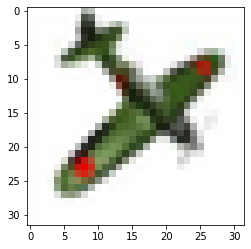

In [ ]:
plt.imshow(val[98][0].cpu().detach().numpy().squeeze().transpose(1,2,0))

In [ ]:
images = val[98][0].unsqueeze(0).to(args.device)
labels = torch.tensor(val[98][1]).unsqueeze(0).to(args.device)
y_pred = model(images)

[]

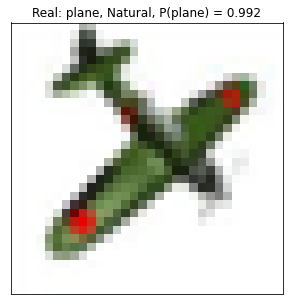

In [ ]:
images.requires_grad = False

fig, axes = plt.subplots(1, 1, figsize=(5,5))

axes.imshow(images.cpu().detach().numpy().squeeze().transpose(1,2,0))
axes.set_title(
    f'Real: {classes[labels]}, Natural, '
    f'P({classes[y_pred.argmax(dim=1).item()]}) = '
    f'{np.round(y_pred.softmax(dim=1)[0, y_pred.argmax(dim=1).item()].item(), 3)}')
axes.set_xticks([])
axes.set_yticks([])

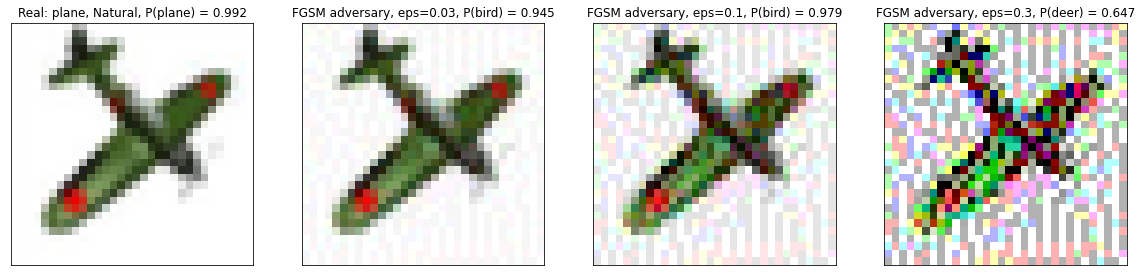

In [ ]:
visualise_adversarial_examples_fgsm(model, *val[98], args.device)

## Original Adversarial training

In [ ]:
# Train the model
train_acc = []
val_acc = []
val_adv_acc = []

for epoch in range(args.num_epochs):
  adv_model_fgsm.train()
  total = 0
  correct = 0

  pbar = tqdm(total=len(train_loader), desc='Epoch {}'.format(epoch+1))
  
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    # Train on original images
    # Forward pass
    optimizer.zero_grad()
    outputs = adv_model_fgsm(images)
    loss = loss_fn(outputs, labels)
    # Backward and optimize
    loss.backward()
    # optimizer.step()
    
    if args.adversarial_training:
      # Create adversarial examples
      images_adv = fgsm_attack(images, args.epsilon, images.grad.data)
      
      # Train on adversarial images
      # Forward pass
      optimizer.zero_grad()
      outputs = adv_model_fgsm(images_adv)
      loss = loss_fn(outputs, labels)
      # Backward and optimize
      loss.backward()
      optimizer.step()
    
    pred = torch.max(outputs.data, 1)[1]  
    total += labels.size(0)
    correct += (pred == labels).sum().item()
    
    pbar.update(1)
    
  train_acc.append(correct / total)
  
  # # Test the model
  # adv_model_fgsm.eval()
  # correct_test_clean = 0
  # total_test_clean = 0
  # correct_test_adv = 0
  # total_test_adv = 0
  # for images_test, labels_test in test_loader:
  #   images_test, labels_test = images_test.to(args.device), labels_test.to(args.device)
  #   images_test.requires_grad = True
  #   
  #   output_test = adv_model_fgsm(images_test)
  #   
  #   pred_test_clean = torch.max(output_test.data, 1)[1] # save the pred_test_cleaniction of the adversarial sample
  #   total_test_clean += labels_test.size(0)
  #   correct_test_clean += (pred_test_clean == labels_test).sum().item()  
  #   
  #   if args.adversarial_testing:
  #     loss_test_adv = criterion(output_test, labels_test)
  #     adv_model_fgsm.zero_grad()
  #     loss_test_adv.backward()
  #     data_grad_test_adv = images_test.grad.data
  #     perturbed_images_test = fgsm_attack(images_test, args.epsilon, data_grad_test_adv)
  #     output_test_adv = adv_model_fgsm(perturbed_images_test.to(args.device))
  #   
  #   pred_test_adv = torch.max(output_test_adv.data, 1)[1] # save the pred_test_adviction of the adversarial sample
  #   total_test_adv += labels_test.size(0)
  #   correct_test_adv += (pred_test_adv == labels_test).sum().item()  
  #   
  # val_acc.append(100 * correct_test_clean / total_test_clean)
  # val_adv_acc.append(100 * correct_test_adv / total_test_adv)
  # 
  curr_lr = optimizer.param_groups[0]['lr']
  scheduler.step(train_acc[epoch])
  
  pbar_dict = {'loss':loss.item(),
               'acc':train_acc[epoch],
  #             'val_loss': val_loss.item(),
  #             'val_acc':val_acc[epoch],
               'LR':curr_lr}

  pbar.set_postfix(pbar_dict)

No handles with labels found to put in legend.


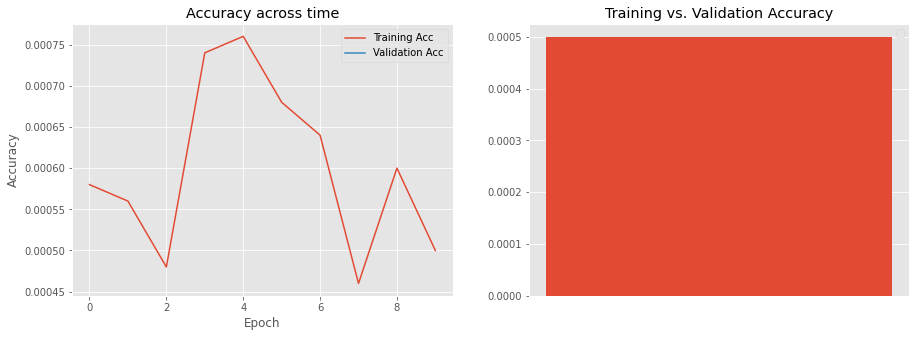

<Figure size 1008x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    
    index = np.arange(1)
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(14,7))
    
    axes[0].set_title('Accuracy across time')
    axes[0].plot(train_acc, label='Training Acc')
    axes[0].plot(val_acc, label='Validation Acc')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    axes[1].set_title('Training vs. Validation Accuracy')
    axes[1].bar(index, train_acc[-1], 0.2)
    #axes[1].bar(index+0.2, val_acc[-1], 0.2)
    axes[1].set_xticks([])
    axes[1].legend()
    
    plt.show()
    plt.savefig('naturalTraining1.png')

In [ ]:
# Model
net_args = {
    "block": ResidualBlock,
    "channels": train_loader.dataset[0][0].shape[0],
    "layers": [2, 2, 2],
    "num_classes": 10
}
adv_model_fgsm = ResNet(**net_args).to(args.device)

args.adversarial_training = True
args.learning_rate = 0.001

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(adv_model_fgsm.parameters(), lr=args.learning_rate)
scheduler = ReduceLROnPlateau(optimizer, patience = 5)

In [ ]:
# Train the model
train_acc = []
val_acc = []
val_adv_acc = []

for epoch in range(args.num_epochs):
  adv_model_fgsm.train()
  total = 0
  correct = 0
  
  pbar = tqdm(total=len(train_loader), desc='Epoch {}'.format(epoch+1))
  
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    # Train on original images
    # Forward pass
    optimizer.zero_grad()
    outputs = adv_model_fgsm(images)
    loss = loss_fn(outputs, labels)
    # Backward and optimize
    loss.backward()
    optimizer.step()
    
    if args.adversarial_training:
      # Create adversarial examples
      images_adv = fgsm_attack(images, args.epsilon, images.grad.data)
      
      # Train on adversarial images
      # Forward pass
      optimizer.zero_grad()
      outputs = adv_model_fgsm(images_adv)
      loss = loss_fn(outputs, labels)
      # Backward and optimize
      loss.backward()
      optimizer.step()
      
    pred = torch.max(outputs.data, 1)[1]
    total += labels.size(0)
    correct += (pred == labels).sum().item()
    
    pbar.update(1)
    
  train_acc.append(correct / total)
  
  curr_lr = optimizer.param_groups[0]['lr']
  scheduler.step(train_acc[epoch])
  
  pbar_dict = {
      'loss':loss.item(),
      'acc':train_acc[epoch],
      'LR':curr_lr
      }
  pbar.set_postfix(pbar_dict)

  # break

## Previous training

In [ ]:
# Train the model
train_acc = []
val_acc = []

for epoch in range(args.num_epochs):
  model.train()
  total = 0
  correct = 0

  pbar = tqdm(total=len(train_loader), desc='Epoch {}'.format(epoch+1))
  
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    # Train on original images
    outputs, loss = forward_pass(model, images, labels, loss_fn, optimizer)
    
    if args.adversarial_training:
      # Create adversarial examples
      images_adv = fgsm_attack(images, args.epsilon, images.grad.data)
      
      # Train on adversarial images
      outputs, loss = forward_pass(model, images_adv, labels, loss_fn, optimizer)
    
    pred = torch.max(outputs.data, 1)[1]  
    total += labels.size(0)
    correct += (pred == labels).sum().item()
    
    pbar.update(1)
    
  train_acc.append(correct / total)
  
  # Test the model
  model.eval()
  total = 0
  correct = 0
  
  for images, labels in val_loader:
    images, labels = images.to(args.device), labels.to(args.device)
    images.requires_grad = True
    
    outputs = model(images)
    val_loss = loss_fn(outputs, labels)
    
    if args.adversarial_testing:
      val_loss.backward()
      perturbed_images = fgsm_attack(images, args.epsilon, images.grad.data)
      
      outputs = model(perturbed_images.to(args.device))
      val_loss = loss_fn(outputs, labels)
	  
    pred = torch.max(outputs.data, 1)[1] # save the prediction of the adversarial sample
    total += labels.size(0)
    correct += (pred == labels).sum().item()

  val_acc.append(correct / total)
  
  curr_lr = optimizer.param_groups[0]['lr']
  scheduler.step(train_acc[epoch])
  
  pbar_dict = {'loss':loss.item(),
               'acc':train_acc[epoch],
               'val_loss': val_loss.item(),
               'val_acc':val_acc[epoch],
               'LR':curr_lr}

  pbar.set_postfix(pbar_dict)

## PGD atack with small step

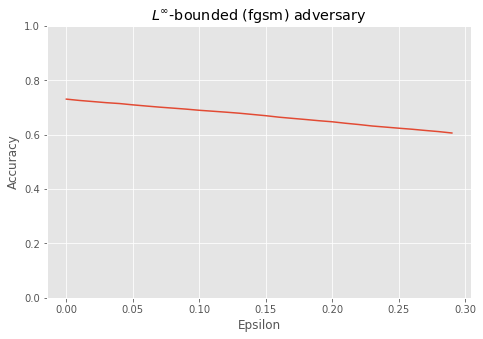

In [ ]:
fgsm_attack_range = np.arange(0.0, 0.3, 0.01)
fgsm_acc = []
for eps in fgsm_attack_range:
    fgsm_acc.append(evaluate_against_adversary(adv_model_fgsm, k=40, eps=eps, step=0.01, norm='pgd', device=args.device))


with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('$L^{\infty}$-bounded (fgsm) adversary')
    axes.plot(fgsm_attack_range, fgsm_acc)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()

In [ ]:
files.download('./data/compareAttacks.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

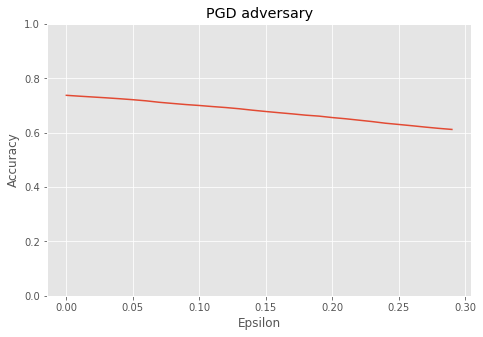

<Figure size 432x288 with 0 Axes>

In [ ]:
pgd_attack_range = np.arange(0.0, 0.3, 0.01)
pgd_acc = []
for eps in fgsm_attack_range:
    pgd_acc.append(evaluate_against_adversary(adv_model_fgsm, val_loader, k=40, eps=eps, step=0.1, norm='pgd', device=args.device))
    

with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('PGD adversary')
    axes.plot(pgd_attack_range, pgd_acc)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()
    plt.savefig('./data/modifiedAttack.jpg')

In [ ]:
pgd_accuracy_robust = {'pgd_attack_range': list(pgd_attack_range), 'pgd_acc': pgd_acc}

with open('./data/pgd_accuracy_robust.json', 'w') as f:
    json.dump(pgd_accuracy_robust, f)

In [ ]:
files.download('./data/modifiedAttack.jpg')
files.download('./data/pgd_accuracy_robust.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pgd_attack_range = np.arange(0.0, 0.3, 0.01)
pgd_acc = []
for eps in fgsm_attack_range:
    pgd_acc.append(evaluate_against_adversary(model, val_loader, k=40, eps=eps, step=0.1, norm='pgd', device=args.device))
    

with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('PGD adversary')
    axes.plot(pgd_attack_range, pgd_acc)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()
    plt.savefig('./data/modifiedAttackNaturalModel.jpg')

In [ ]:
pgd_accuracy_robust = {'pgd_attack_range': list(pgd_attack_range), 'pgd_acc': pgd_acc}

with open('./data/pgd_accuracy_natural.json', 'w') as f:
    json.dump(pgd_accuracy_robust, f)

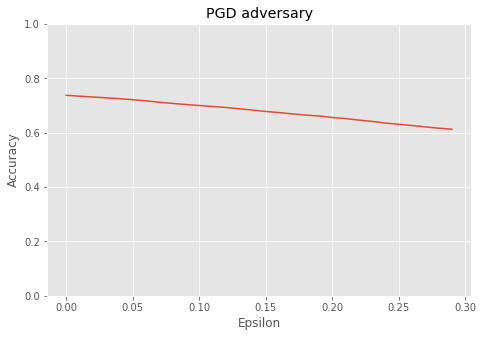

<Figure size 432x288 with 0 Axes>

In [ ]:
pgd_attack_range = np.arange(0.0, 0.3, 0.01)
pgd_acc = []
for eps in pgd_attack_range:
    pgd_acc.append(evaluate_against_adversary(adv_model_fgsm, val_loader, k=40, eps=eps, step=1, norm='pgd', device=args.device))
    

with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('PGD adversary')
    axes.plot(pgd_attack_range, pgd_acc)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()
    plt.savefig('./data/modifiedAttackStep=1.jpg')

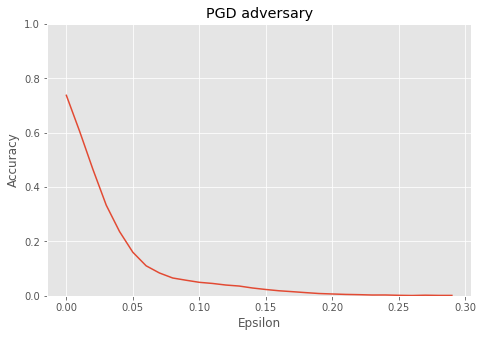

<Figure size 432x288 with 0 Axes>

In [ ]:
pgd_attack_range = np.arange(0.0, 0.3, 0.01)
pgd_acc = []
for eps in pgd_attack_range:
    pgd_acc.append(evaluate_against_adversary(adv_model_fgsm, val_loader, k=40, eps=eps, step=1, norm='i-fgsm', device=args.device))
    

with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('PGD adversary')
    axes.plot(pgd_attack_range, pgd_acc)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()
    plt.savefig('./data/modifiedAttackIFGSM.png')

In [ ]:
pgd_accuracy_robust = {'pgd_attack_range': list(pgd_attack_range), 'pgd_acc': pgd_acc}

with open('./data/pgd_accuracy_robust_step=1.json', 'w') as f:
    json.dump(pgd_accuracy_robust, f)

In [ ]:
def evaluate_against_adversary(model, val_loader, k, eps, step, norm, device):
    total = 0
    acc = 0
    for x, y in val_loader:
        total += x.size(0)
        
        if norm == 'fgsm':
            x_adv = iterated_fgsm(
                model, x.to(device), y.to(device), torch.nn.CrossEntropyLoss(), k=k, step=step, eps=eps, norm='inf')
        elif norm == 'pgd':
            x_adv = pgd(
                model, x.to(device), y.to(device), torch.nn.CrossEntropyLoss(), k=k, step=step, eps=eps, norm=2)
        elif norm == 'i-fgsm':
            x_adv = iterated_fgsm(
                model, x.to(device), y.to(device), torch.nn.CrossEntropyLoss(), k=k, step=step, eps=eps, norm='inf')    

        
        y_pred = model(x_adv)

        acc += olympic.metrics.accuracy(y.to(device), y_pred) * x.size(0)

    return acc/total

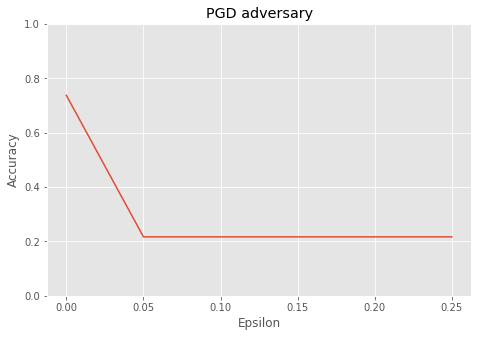

<Figure size 432x288 with 0 Axes>

In [ ]:
# pgd_attack_range = np.arange(0.0, 0.3, 0.01)
pgd_attack_range = np.arange(0.0, 0.3, 0.05)
pgd_acc = []
for eps in pgd_attack_range:
    pgd_acc.append(evaluate_against_adversary(adv_model_fgsm, val_loader, k=40, eps=eps, step=0.001, norm='i-fgsm', device=args.device))
    

with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('PGD adversary')
    axes.plot(pgd_attack_range, pgd_acc)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()
    plt.savefig('./data/modifiedAttackIFGSM.png')

In [ ]:
pgd_accuracy_robust = {'pgd_attack_range': list(pgd_attack_range), 'pgd_acc': pgd_acc}

with open('./data/ifgsm_accuracy_robust_step=1e-3.json', 'w') as f:
    json.dump(pgd_accuracy_robust, f)

In [ ]:
files.download('./data/modifiedAttackIFGSM.jpg')
files.download('./data/ifgsm_accuracy_robust_step=1e-3.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

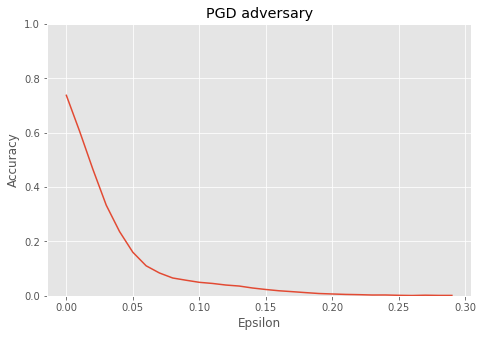

<Figure size 432x288 with 0 Axes>

In [ ]:
pgd_attack_range = np.arange(0.0, 0.3, 0.01)
pgd_acc = []
for eps in pgd_attack_range:
    pgd_acc.append(evaluate_against_adversary(adv_model_fgsm, val_loader, k=40, eps=eps, step=1, norm='i-fgsm', device=args.device))
    

with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('PGD adversary')
    axes.plot(pgd_attack_range, pgd_acc)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()
    plt.savefig('./data/modifiedAttackIFGSM.png')

In [ ]:
files.download('./data/modifiedAttackNaturalModel.jpg')
files.download('./data/pgd_accuracy_natural.json')
files.download('./data/modifiedAttackStep=1.jpg')
files.download('./data/pgd_accuracy_robust_step=1.json')

In [ ]:
files.download('utils.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## load json

In [ ]:
with open('./data/fgsm_accuracy_robust.json') as F:
    fgsm_accuracy_robust = json.load(F)

## Plots

### Load result files

In [ ]:
with open('./data/results/train_results.json') as F:
    train_results = json.load(F)

with open('./data/results/adv_train_results.json') as F:
    adv_train_results = json.load(F)

with open('./data/results/fgsm_accuracy_natural.json') as F:
    fgsm_accuracy_natural = json.load(F)

with open('./data/results/fgsm_accuracy_robust.json') as F:
    fgsm_accuracy_robust = json.load(F)

# with open('./data/results/iter_fgsm_accuracy_robust.json') as F:
#     iter_fgsm_accuracy_robust = json.load(F)
# 
# with open('./data/results/pgd_accuracy_robust.json') as F:
#     iter_fgsm_accuracy_robust = json.load(F)

### Plot natural accuracy

No handles with labels found to put in legend.


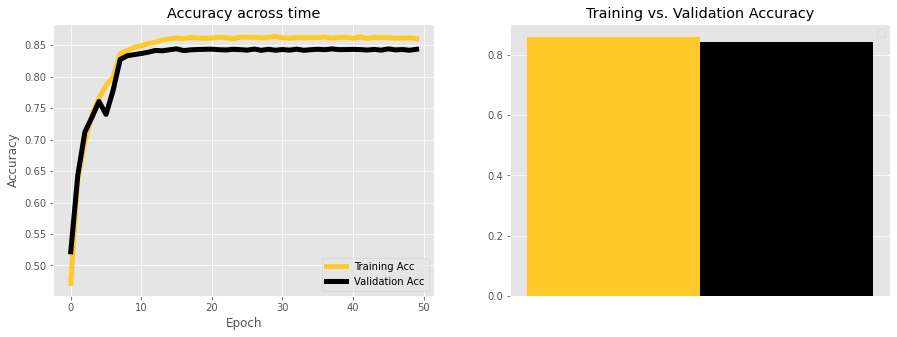

<Figure size 1008x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    
    index = np.arange(1)
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(14,7))
    
    axes[0].set_title('Accuracy across time')
    axes[0].plot(train_results['train_acc'], label='Training Acc', color='#ffca29', linewidth=5)
    axes[0].plot(train_results['val_acc'], label='Validation Acc', color='black', linewidth=5)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    axes[1].set_title('Training vs. Validation Accuracy')
    axes[1].bar(index, train_results['train_acc'][-1], 0.2, color='#ffca29')
    axes[1].bar(index+0.2, train_results['val_acc'][-1], 0.2, color='')
    axes[1].set_xticks([])
    axes[1].legend()
    
    plt.show()
    plt.savefig('./data/images/naturalTraining1.png')

No handles with labels found to put in legend.


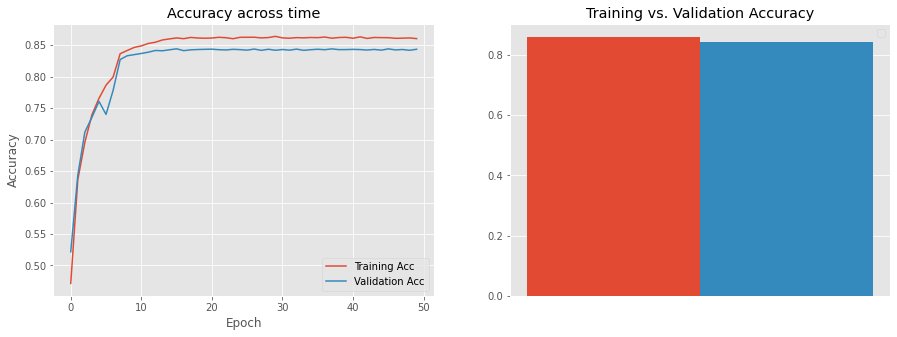

<Figure size 1008x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    
    index = np.arange(1)
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(14,7))
    
    axes[0].set_title('Accuracy across time')
    axes[0].plot(train_acc, label='Training Acc')
    axes[0].plot(val_acc, label='Validation Acc')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    axes[1].set_title('Training vs. Validation Accuracy')
    axes[1].bar(index, train_acc[-1], 0.2)
    axes[1].bar(index+0.2, val_acc[-1], 0.2)
    axes[1].set_xticks([])
    axes[1].legend()
    
    plt.show()
    plt.savefig('./data/images/naturalTraining1.png')

In [ ]:
train_results = {'train_acc': train_acc, 'val_acc': val_acc}

with open('./data/results/train_results.json', 'w') as f
    json.dump(train_results, f)

### Plot robust accuracy

No handles with labels found to put in legend.


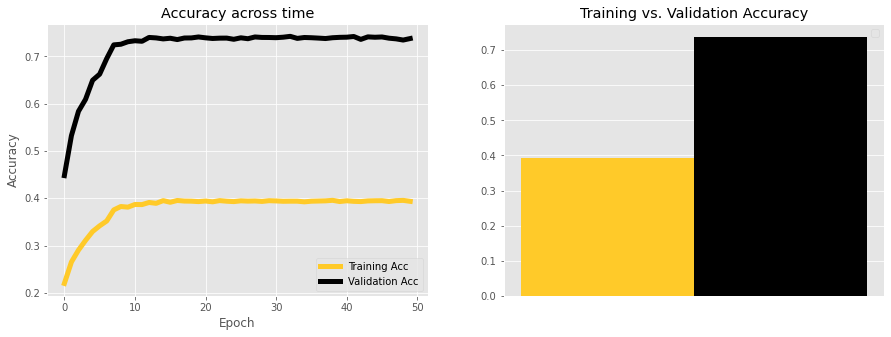

<Figure size 1008x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    
    index = np.arange(1)
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(14,7))
    
    axes[0].set_title('Accuracy across time')
    axes[0].plot(adv_train_results['train_acc'], label='Training Acc', color='#ffca29', linewidth=5)
    axes[0].plot(adv_train_results['val_acc'], label='Validation Acc', color='black', linewidth=5)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    axes[1].set_title('Training vs. Validation Accuracy')
    axes[1].bar(index, adv_train_results['train_acc'][-1], 0.2, color='#ffca29')
    axes[1].bar(index+0.2, adv_train_results['val_acc'][-1], 0.2, color='black')
    axes[1].set_xticks([])
    axes[1].legend()
    
    plt.show()
    plt.savefig('./data/images/naturalTraining1.png')

No handles with labels found to put in legend.


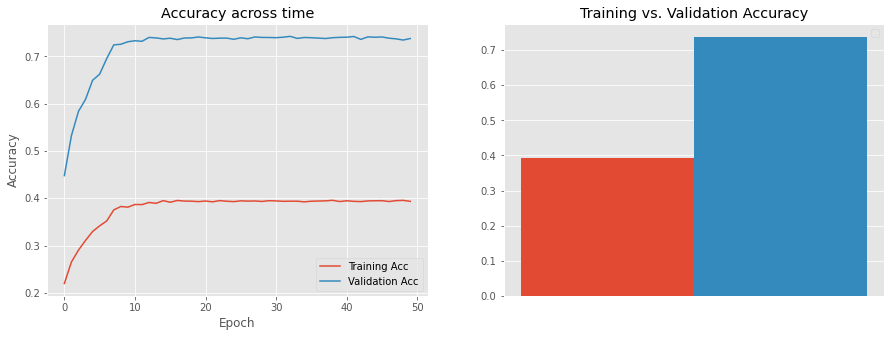

<Figure size 1008x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    
    index = np.arange(1)
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(14,7))
    
    axes[0].set_title('Accuracy across time')
    axes[0].plot(train_acc, label='Training Acc')
    axes[0].plot(val_acc, label='Validation Acc')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    axes[1].set_title('Training vs. Validation Accuracy')
    axes[1].bar(index, train_acc[-1], 0.2)
    axes[1].bar(index+0.2, val_acc[-1], 0.2)
    axes[1].set_xticks([])
    axes[1].legend()
    
    plt.show()
    plt.savefig('./data/images/adversarialTraining.png')

In [ ]:
adv_train_results = {'train_acc': train_acc, 'val_acc': val_acc}

with open('./data/results/adv_train_results.json', 'w') as f:
    json.dump(adv_train_results, f)

In [ ]:
files.download('./data/images/adversarialTraining.png')
files.download('./data/results/adv_train_results.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Plot results of FGSM attack on natural model

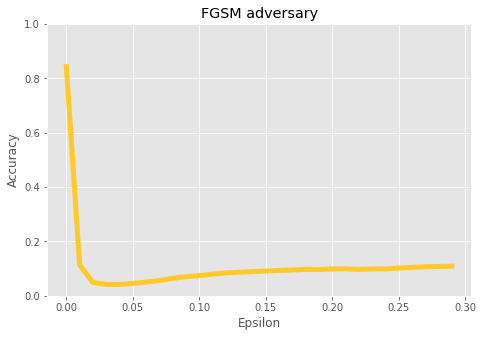

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('FGSM adversary')
    axes.plot(fgsm_accuracy_natural['fgsm_attack_range'], fgsm_accuracy_natural['fgsm_acc'], color='#ffca29', linewidth=5)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()
    plt.savefig('./data/images/quantifyingAdversary.png')

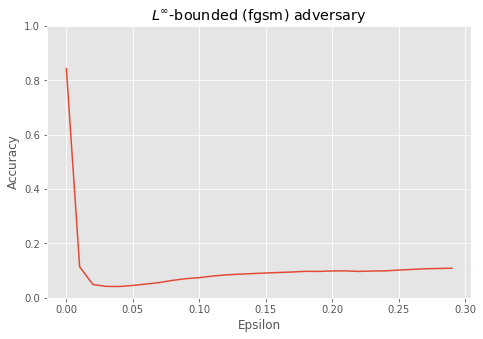

<Figure size 432x288 with 0 Axes>

In [ ]:
fgsm_attack_range = np.arange(0.0, 0.3, 0.01)
fgsm_acc = []
for eps in fgsm_attack_range:
    fgsm_acc.append(evaluate_against_adversary(model, val_loader, k=1, eps=eps, step=1, norm='fgsm', device=args.device))


with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('FGSM adversary')
    axes.plot(fgsm_attack_range, fgsm_acc)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()
    plt.savefig('./data/images/quantifyingAdversary.png')

In [ ]:
fgsm_accuracy_natural = {'fgsm_attack_range': list(fgsm_attack_range), 'fgsm_acc': fgsm_acc}

with open('./data/results/fgsm_accuracy_natural.json', 'w') as f:
    json.dump(fgsm_accuracy_natural, f)

In [ ]:
files.download('./data/images/quantifyingAdversary.png')
files.download('./data/results/fgsm_accuracy_natural.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Plot results of FGSM attack on robust model

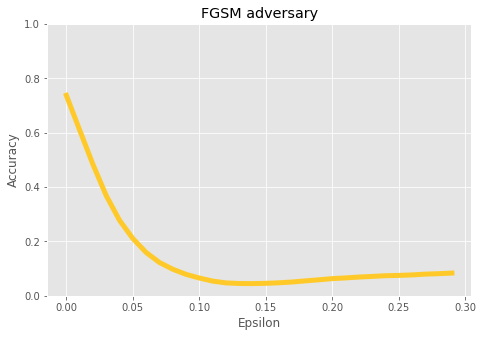

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('FGSM adversary')
    axes.plot(fgsm_accuracy_robust['fgsm_attack_range'], fgsm_accuracy_robust['fgsm_acc'], color='#ffca29', linewidth=5)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()
    plt.savefig('./data/images/quantifyingAdversary.png')

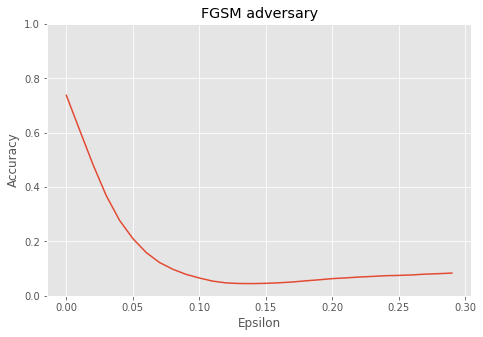

<Figure size 432x288 with 0 Axes>

In [ ]:
fgsm_attack_range = np.arange(0.0, 0.3, 0.01)
fgsm_acc = []
for eps in fgsm_attack_range:
    fgsm_acc.append(evaluate_against_adversary(adv_model_fgsm, val_loader, k=1, eps=eps, step=1, norm='fgsm', device=args.device))

with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('FGSM adversary')
    axes.plot(fgsm_attack_range, fgsm_acc)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    
    plt.show()
    plt.savefig('./data/images/evalutingRobustness.png')

In [ ]:
fgsm_accuracy_robust = {'fgsm_attack_range': list(fgsm_attack_range), 'fgsm_acc': fgsm_acc}

with open('./data/results/fgsm_accuracy_robust.json', 'w') as f:
    json.dump(fgsm_accuracy_robust, f)

In [ ]:
files.download('./data/images/evalutingRobustness.png')
files.download('./data/results/fgsm_accuracy_robust.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Plot results of modified attack on robust model

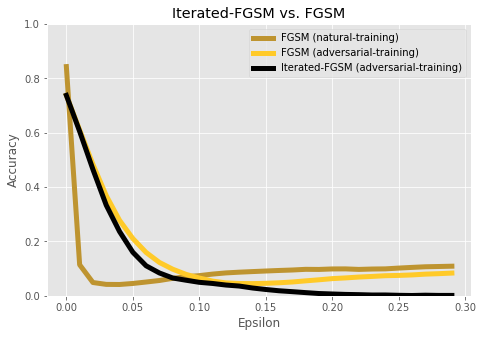

<Figure size 432x288 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('Iterated-FGSM vs. FGSM')
    axes.plot(fgsm_accuracy_natural['fgsm_attack_range'], fgsm_accuracy_natural['fgsm_acc'], label='FGSM (natural-training)', color='#be9430', linewidth=5)
    axes.plot(fgsm_accuracy_robust['fgsm_attack_range'], fgsm_accuracy_robust['fgsm_acc'], label='FGSM (adversarial-training)', color='#ffca29', linewidth=5)
    axes.plot(iter_fgsm_accuracy_robust['iter_fgsm_attack_range'], iter_fgsm_accuracy_robust['iter_fgsm_acc'], label='Iterated-FGSM (adversarial-training)', color='black', linewidth=5)
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    axes.legend()
    
    plt.show()
    plt.savefig('./data/images/iter_fgsm_accuracy_robust.png')

In [ ]:
iter_fgsm_accuracy_robust.keys()

dict_keys(['iter_fgsm_attack_range', 'iter_fgsm_acc'])

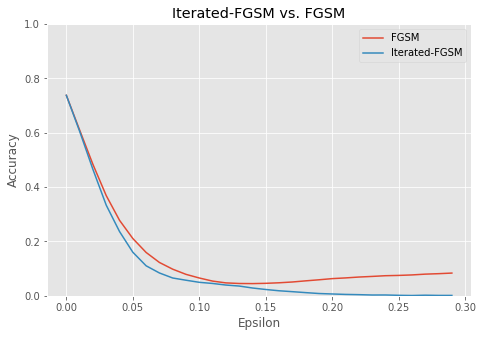

<Figure size 432x288 with 0 Axes>

In [ ]:
iter_fgsm_attack_range = np.arange(0.0, 0.3, 0.01)
iter_fgsm_acc = []
for eps in iter_fgsm_attack_range:
    iter_fgsm_acc.append(evaluate_against_adversary(adv_model_fgsm, val_loader, k=40, eps=eps, step=1, norm='i-fgsm', device=args.device))

with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 1, figsize=(7.6,5))
    
    axes.set_title('Iterated-FGSM vs. FGSM')
    axes.plot(fgsm_accuracy_robust['fgsm_attack_range'], fgsm_accuracy_robust['fgsm_acc'], label='FGSM')
    axes.plot(iter_fgsm_attack_range, iter_fgsm_acc, label='Iterated-FGSM')
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0,1))
    axes.legend()
    
    plt.show()
    plt.savefig('./data/images/iter_fgsm_accuracy_robust.png')

In [ ]:
iter_fgsm_accuracy_robust = {'iter_fgsm_attack_range': list(iter_fgsm_attack_range), 'iter_fgsm_acc': iter_fgsm_acc}

with open('./data/results/iter_fgsm_accuracy_robust.json', 'w') as f:
    json.dump(iter_fgsm_accuracy_robust, f)

In [ ]:
files.download('./data/images/iter_fgsm_accuracy_robust.png')
files.download('./data/results/iter_fgsm_accuracy_robust.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## *Early stopping*

https://github.com/ncullen93/torchsample/blob/master/README.md